# Receive output from SR generator for a low resoultion image

## install lpips library

In [ ]:
pip install lpips

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# Imports

In [ ]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Resize, Compose

import lpips

from skimage.metrics import structural_similarity as SSIM

## Create Required Folders

In [ ]:
input_dir = 'input'
in_hr_dir = 'input/HR'
in_lr_dir = 'input/LR'
output_dir = 'output'
output_hr_dir = 'output/HR'

os.makedirs(input_dir, exist_ok=True)
os.makedirs(in_hr_dir, exist_ok=True)
os.makedirs(in_lr_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_hr_dir, exist_ok=True)

# SR Generator class

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        return x + self.conv2(self.prelu(self.conv1(x)))

class GSR(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residuals=5):
        super(GSR, self).__init__()
        self.encoder = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)
        self.resnet = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residuals)])
        self.decoder = nn.Conv2d(64, out_channels, kernel_size=5, padding=2)
        self.upsample = nn.Upsample(scale_factor=4, mode='bicubic')

    def forward(self, x):
        x = self.upsample(x)
        x = self.encoder(x)
        x = self.resnet(x)
        x = self.decoder(x)
        return torch.clamp(x, 0, 1)

## Load the weights of the pre-trained model

In [ ]:
# Model, Optimizer, and Losses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_sr = GSR().to(device)

# Load the pre-trained weights
generator_sr.load_state_dict(torch.load('generator_sr.pth'))

# Set the model to evaluation mode
generator_sr.eval()

GSR(
  (encoder): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (resnet): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

## Prepare the low-resolution image

In [ ]:
# Load the low-resolution image
lr_image = Image.open('input/LR/example_img.jpg').convert('RGB') # Replace example_img.jpg with your image file.

# Preprocess the image: Convert to tensor and add a batch dimension
transform = ToTensor()
lr_image_tensor = transform(lr_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

## Generate the high-resolution image

In [ ]:
# Generate the high-resolution image
with torch.no_grad():  # Disable gradient calculation for inference
    output = generator_sr(lr_image_tensor)

# Remove the batch dimension and convert back to a PIL image
sr_image_tensor = output.squeeze(0)  # Remove batch dimension
to_pil = ToPILImage()
sr_image = to_pil(sr_image_tensor.cpu())  # Move to CPU and convert to PIL image

## Save high resolution image output

In [ ]:
# Save the high-resolution image
sr_image.save('output/HR/super_resolved_image.jpg')

## Metrics

In [ ]:
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

In [ ]:
def calculate_ssim(img1, img2, win_size=7):
    img1_np = img1.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and NumPy array
    img2_np = img2.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and NumPy array
    ssim_value = SSIM(img1_np, img2_np, multichannel=True, data_range=img1_np.max() - img1_np.min(), win_size=win_size)
    return ssim_value

In [ ]:
def calculate_lpips(img1, img2, loss_fn):
    # Ensure img1 and img2 are normalized and have the same dimensions
    lpips_value = loss_fn(img1, img2)
    return lpips_value.item()

## Load images and run calaculation of metrics for the given images

In [ ]:
sr_image = Image.open('output/HR/super_resolved_image.jpg').convert('RGB')
hr_image = Image.open('input/HR/0a4baa7dea1785.jpg').convert('RGB')

# Convert to tensors (this will normalize the images to the range [0, 1])
sr_image_tensor = ToTensor()(sr_image)  # Shape will be [3, H, W]
hr_image_tensor = ToTensor()(hr_image)  # Shape will be [3, H, W]

# Add a batch dimension (shape will be [1, 3, H, W])
sr_image_tensor = sr_image_tensor.unsqueeze(0)
hr_image_tensor = hr_image_tensor.unsqueeze(0)

# Resize sr_image_tensor to match the dimensions of hr_image_tensor
sr_image_tensor_resized = F.interpolate(sr_image_tensor, size=hr_image_tensor.shape[2:], mode='bilinear', align_corners=False)

# Normalize to [-1, 1] for LPIPS
sr_image_tensor_lpips = 2 * sr_image_tensor - 1
hr_image_tensor_lpips = 2 * hr_image_tensor - 1

sr_image_tensor_lpips = F.interpolate(sr_image_tensor_lpips, size=hr_image_tensor_lpips.shape[2:], mode='bilinear', align_corners=False)

In [ ]:
# Initialize LPIPS model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
# PSNR
psnr_value = calculate_psnr(sr_image_tensor_resized, hr_image_tensor)
print(f"PSNR: {psnr_value} dB")

# SSIM
ssim_value = calculate_ssim(sr_image_tensor_resized, hr_image_tensor, win_size=3)
print(f"SSIM: {ssim_value}")

# LPIPS
lpips_value = calculate_lpips(sr_image_tensor_lpips, hr_image_tensor_lpips)
print(f"LPIPS: {lpips_value}")

PSNR: 26.138442993164062 dB
SSIM: 0.7226033561416215
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS: 0.518660843372345


# Run Test Set with Metrics Graph per Epoch

## Load Test Set

In [ ]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted([file for file in os.listdir(lr_dir) if file.endswith(('.png', '.jpg', '.jpeg'))])
        self.hr_images = sorted([file for file in os.listdir(hr_dir) if file.endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_image_path = os.path.join(self.hr_dir, self.hr_images[idx])

        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths
lr_dir = '/content/drive/My Drive/example_test_set/LR'
hr_dir = '/content/drive/My Drive/example_test_set/HR'

# Dataset and DataLoader
# Define a transform to resize images to 256x256 and convert to tensor
transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

dataset = SRDataset(lr_dir, hr_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# Function to compute metrics
def compute_metrics(lr_image, hr_image, sr_image, loss_fn_vgg):
    # Resize SR image tensor to match the dimensions of HR image tensor
    sr_image_resized = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bilinear', align_corners=False)

    # Calculate metrics using the resized SR image
    psnr_value = calculate_psnr(sr_image_resized, hr_image)
    ssim_value = calculate_ssim(sr_image_resized, hr_image, win_size=3)
    lpips_value = calculate_lpips(sr_image_resized, hr_image, loss_fn_vgg)

    return ssim_value, psnr_value, lpips_value

In [ ]:
# Function to evaluate the model on the entire test set
def evaluate_model(dataloader, model, loss_fn_vgg, device):
    ssim_scores = []
    psnr_scores = []
    lpips_scores = []

    for lr_image, hr_image in dataloader:
        lr_image = lr_image.to(device)
        hr_image = hr_image.to(device)

        # Generate the super-resolved image
        with torch.no_grad():
            sr_image = model(lr_image)

        # Compute metrics
        ssim_value, psnr_value, lpips_value = compute_metrics(lr_image, hr_image, sr_image, loss_fn_vgg)

        # Store the metrics
        ssim_scores.append(ssim_value)
        psnr_scores.append(psnr_value)
        lpips_scores.append(lpips_value)

    # Calculate the average metrics
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_lpips = np.mean(lpips_scores)

    return avg_ssim, avg_psnr, avg_lpips

In [ ]:
# Evaluate models
num_models = 30 # Change this according to the number of models you have weights saved.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator_sr = GSR().to(device)

avg_ssim_pe = [0] * num_models
avg_psnr_pe = [0] * num_models
avg_lpips_pe = [0] * num_models

for i in range(num_models):
  generator_sr.load_state_dict(torch.load(f'models/generator_sr_epoch_{i + 1}.pth')) # Load the weights of the given model (per epoch).
  generator_sr.eval()
  avg_ssim, avg_psnr, avg_lpips = evaluate_model(dataloader, generator_sr, loss_fn_vgg, device)

  print(f"Average SSIM {i + 1}: {avg_ssim}")
  print(f"Average PSNR {i + 1}: {avg_psnr} dB")
  print(f"Average LPIPS {i + 1}: {avg_lpips}")
  print('')

  avg_ssim_pe[i] = avg_ssim
  avg_psnr_pe[i] = avg_psnr
  avg_lpips_pe[i] = avg_lpips

Average SSIM 1: 0.8656832114240729
Average PSNR 1: 22.46211995901885 dB
Average LPIPS 1: 0.04092048710488059
Average SSIM 2: 0.8465668257085028
Average PSNR 2: 22.043023648085416 dB
Average LPIPS 2: 0.04809748574539467
Average SSIM 3: 0.8425266708267672
Average PSNR 3: 21.943573112841005 dB
Average LPIPS 3: 0.0520634006674367
Average SSIM 4: 0.8341549289845447
Average PSNR 4: 21.841373920440674 dB
Average LPIPS 4: 0.05814760305953247
Average SSIM 5: 0.8376645012378722
Average PSNR 5: 21.859416317056727 dB
Average LPIPS 5: 0.061716921627521515
Average SSIM 6: 0.839822727778971
Average PSNR 6: 21.843656954941927 dB
Average LPIPS 6: 0.06500365726511788
Average SSIM 7: 0.8386260498857858
Average PSNR 7: 21.890587082615607 dB
Average LPIPS 7: 0.06682698797710517
Average SSIM 8: 0.8408137603237804
Average PSNR 8: 22.065243305983365 dB
Average LPIPS 8: 0.0697149719560036
Average SSIM 9: 0.8374252170716767
Average PSNR 9: 21.95377987402457 dB
Average LPIPS 9: 0.07376078550738317
Average SSIM 1

# Plot Metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_metric(metric_name, history):
  epochs = range(1, len(history) + 1)

  # Plot the metric vs. epoch
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, history, 'b-', marker='o', label=metric_name)
  plt.xlabel('Epoch')
  plt.ylabel(f'{metric_name}')
  plt.title(f'{metric_name} vs. Epoch')
  plt.legend()
  plt.grid(True)
  plt.xticks(range(1, len(history) + 1))
  plt.savefig(f'{metric_name}_vs_epoch.png')
  plt.show()

## Plot SSIM Metric

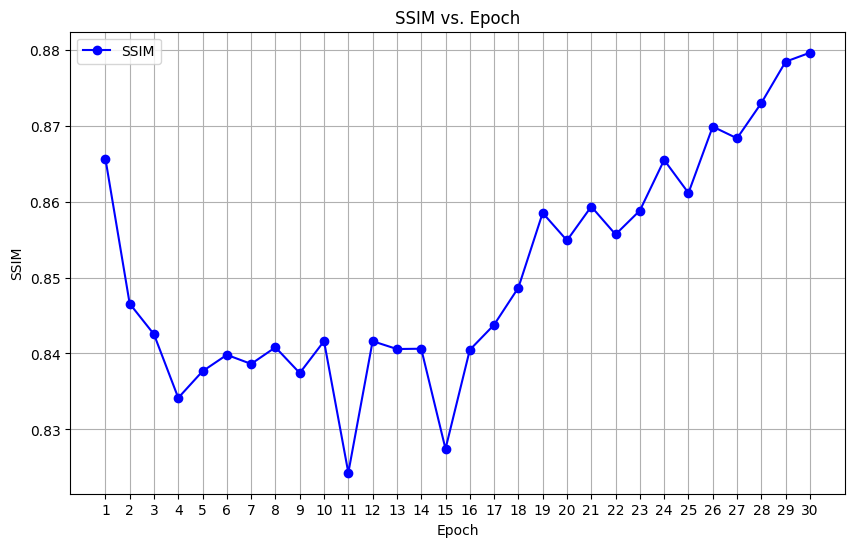

In [ ]:
plot_metric('SSIM', avg_ssim_pe)

## Plot PSNR Metric

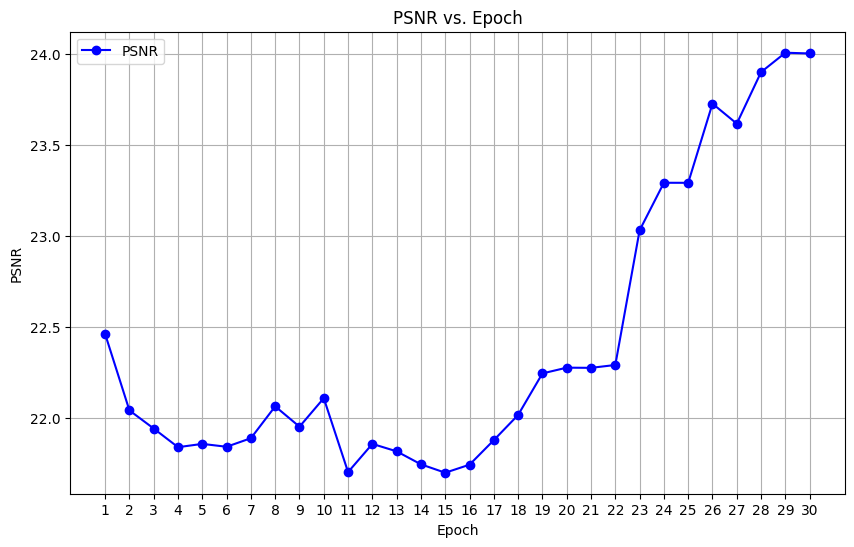

In [ ]:
plot_metric('PSNR', avg_psnr_pe)

# Plot LPIPS Metric

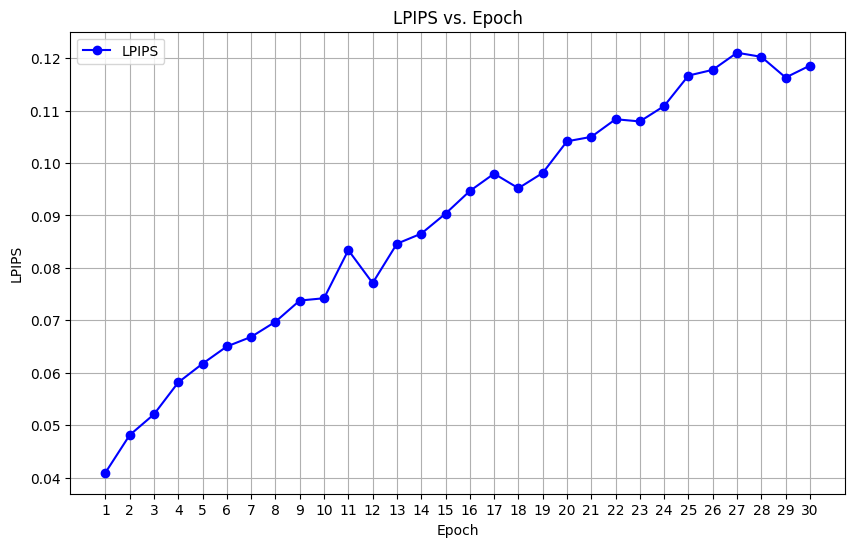

In [ ]:
plot_metric('LPIPS', avg_lpips_pe)